In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.8 MB/s eta 0:00:00


No Standerscaler and no opt

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3872 - loss: 1.0824 - val_accuracy: 0.5111 - val_loss: 0.8881
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5304 - loss: 0.9632 - val_accuracy: 0.7222 - val_loss: 0.7390
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6537 - loss: 0.8569 - val_accuracy: 0.5889 - val_loss: 0.7721
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6270 - loss: 0.8110 - val_accuracy: 0.6333 - val_loss: 0.6996
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7083 - loss: 0.7815 - val_accuracy: 0.7444 - val_loss: 0.6891
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6162 - loss: 0.7763 - val_accuracy: 0.6778 - val_loss: 0.6846
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6330 - loss: 0.7462 - val_accuracy: 0.5444 - val_loss: 0.8403
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6754 - loss: 0.7497 - val_accuracy: 0.7667 - val_loss: 0.5879
Epoch 9/30
7

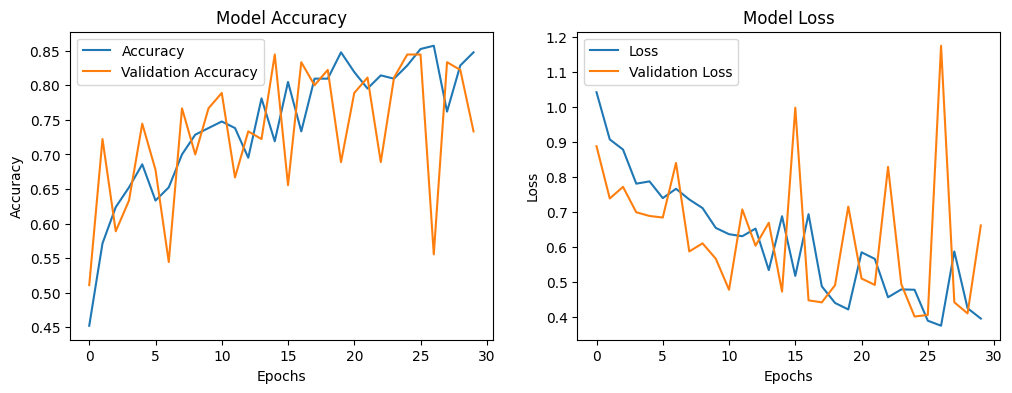

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/No_Options.keras ✅


In [3]:
import os
import numpy as np
import pywt  # PyWavelets for wavelet decomposition
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

# Function to perform wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    decomposed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Concatenate all coefficients to form a feature vector
        features = np.concatenate(coeffs)
        decomposed_data.append(features)
    return np.array(decomposed_data)

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with categorical crossentropy loss (multi-class classification)
    model.compile( loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

    # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


With standerscaler

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3740 - loss: 1.0749 - val_accuracy: 0.5000 - val_loss: 0.9435
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5727 - loss: 0.9308 - val_accuracy: 0.6778 - val_loss: 0.8038
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 974ms/step - accuracy: 0.6632 - loss: 0.8349 - val_accuracy: 0.7333 - val_loss: 0.7137
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6667 - loss: 0.7559 - val_accuracy: 0.7333 - val_loss: 0.6730
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7767 - loss: 0.6729 - val_accuracy: 0.7556 - val_loss: 0.5956
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 981ms/step - accuracy: 0.7709 - loss: 0.6328 - val_accuracy: 0.8000 - val_loss: 0.5562
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7306 - loss: 0.6374 - val_accuracy: 0.8222 - val_loss: 0.5257
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8043 - loss: 0.5852 - val_accuracy: 0.8111 - val_loss: 0.6070
Epoch 9/30
7/7 ━━

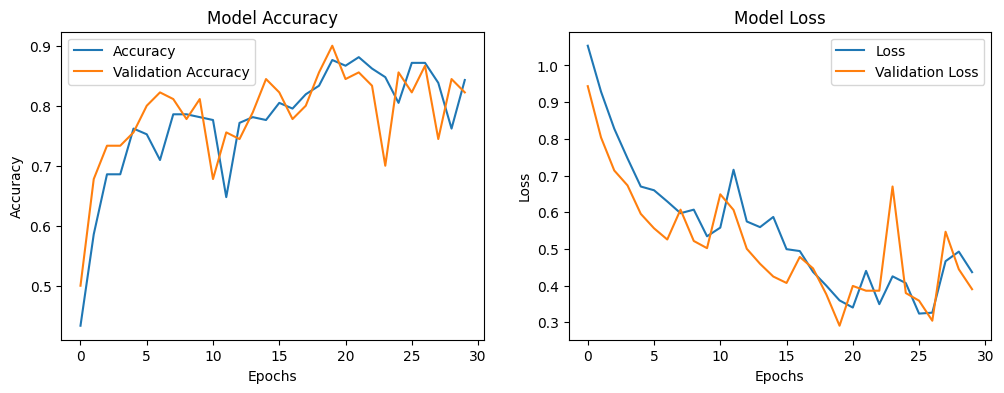

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/With_Stander.keras ✅


In [6]:
import os
import numpy as np
import pywt  # PyWavelets for wavelet decomposition
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

# Function to perform wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    decomposed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Concatenate all coefficients to form a feature vector
        features = np.concatenate(coeffs)
        decomposed_data.append(features)
    return np.array(decomposed_data)

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with categorical crossentropy loss (multi-class classification)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


With Optmiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3877 - loss: 1.1585 - val_accuracy: 0.5889 - val_loss: 0.9884
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5717 - loss: 0.9892 - val_accuracy: 0.5889 - val_loss: 0.9373
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5529 - loss: 0.9188 - val_accuracy: 0.6333 - val_loss: 0.9167
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 954ms/step - accuracy: 0.6194 - loss: 0.8626 - val_accuracy: 0.6889 - val_loss: 0.8474
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 954ms/step - accuracy: 0.6481 - loss: 0.8206 - val_accuracy: 0.6333 - val_loss: 0.7832
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6385 - loss: 0.7696 - val_accuracy: 0.6667 - val_loss: 0.7438
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7016 - loss: 0.7402 - val_accuracy: 0.7444 - val_loss: 0.6449
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 945ms/step - accuracy: 0.7074 - loss: 0.6256 - val_accuracy: 0.7444 - val_loss: 0.6208
Epoch 9/30
7/

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step

Final Evaluation Metrics:
Test Accuracy:  0.8111111111111111
Test Recall (Weighted):  0.8111111111111111
Test Precision (Weighted):  0.8275720164609054
Test F1 Score (Weighted):  0.810752688172043
Confusion Matrix: 
 [[23 12  0]
 [ 3 24  1]
 [ 1  0 26]]
Training time:  291.9592959880829


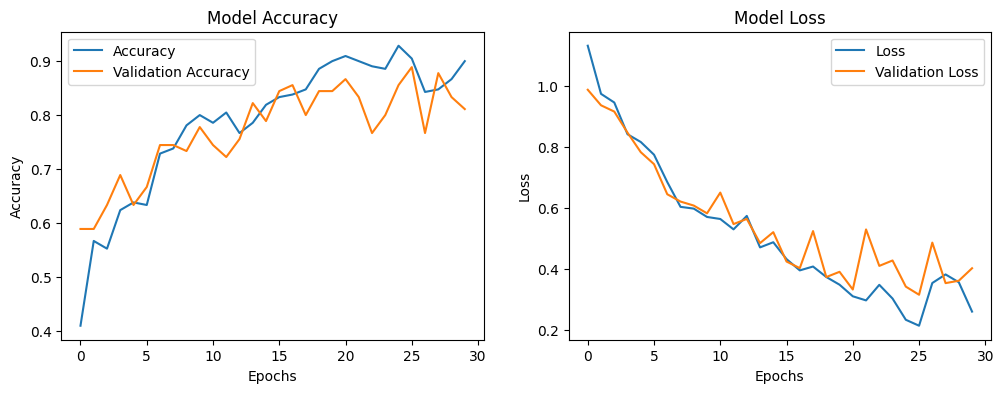

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/With_Optimiser.keras ✅


In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with both standerscaler and op

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3092 - loss: 1.0672 - val_accuracy: 0.3000 - val_loss: 0.9639
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 943ms/step - accuracy: 0.3574 - loss: 0.9392 - val_accuracy: 0.4333 - val_loss: 0.8761
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4877 - loss: 0.8869 - val_accuracy: 0.7222 - val_loss: 0.7678
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7142 - loss: 0.7398 - val_accuracy: 0.6111 - val_loss: 0.6634
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 945ms/step - accuracy: 0.6307 - loss: 0.8381 - val_accuracy: 0.5778 - val_loss: 0.6951
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 935ms/step - accuracy: 0.6823 - loss: 0.6515 - val_accuracy: 0.8667 - val_loss: 0.5775
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7357 - loss: 0.6266 - val_accuracy: 0.7444 - val_loss: 0.5865
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7219 - loss: 0.5327 - val_accuracy: 0.7889 - val_loss: 0.5875
Epoch 9/30
7/7

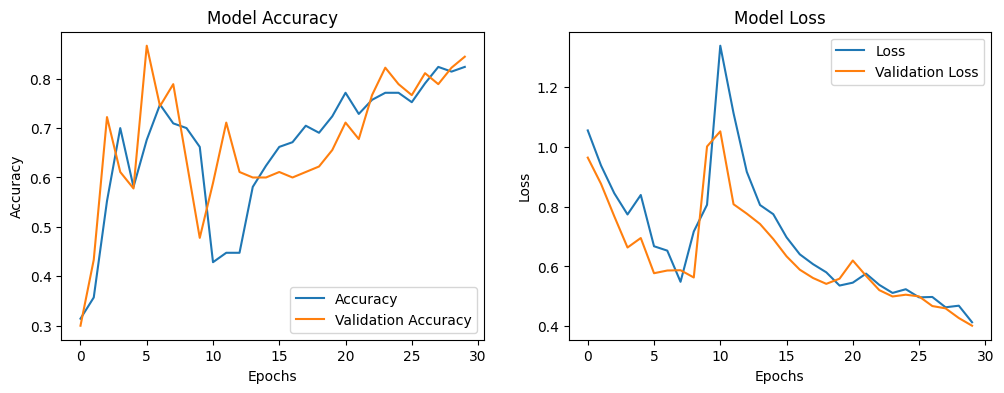

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/With_Options.keras ✅


In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time
import pywt  # Import the PyWavelets library

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function to apply wavelet decomposition
def wavelet_decomposition(data, wavelet='db1', level=1):
    """
    Apply discrete wavelet decomposition to the data.
    :param data: Input data (array of time-series signals)
    :param wavelet: Wavelet function (default is 'db1')
    :param level: Decomposition level (default is 1)
    :return: Decomposed data (coefficients)
    """
    coeffs = []
    for signal in data:
        # Perform wavelet decomposition
        wavelet_coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Flatten the coefficients to create a 1D vector for each signal
        flattened_coeffs = np.concatenate([c.flatten() for c in wavelet_coeffs])
        coeffs.append(flattened_coeffs)

    return np.array(coeffs)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition to each signal in the dataset
    data_all = wavelet_decomposition(data_all, wavelet='db1', level=3)  # Using Daubechies wavelet with level 3 decomposition

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Apply StandardScaler to the data
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform both training and testing data
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with categorical crossentropy loss (multi-class classification)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



  # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN_LSTM/Exp4/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")

